# ASSIGNMENT 1: KNN

Algorithm which can be used for both classification as well as regression predictive problems. K-nearest neighbors (KNN) algorithm uses ‘feature similarity’ to predict the values of new datapoints which further means that the new data point will be assigned a value based on how closely it matches the points in the training set.

In this assignment, it is asked to implement KNN algorithm from the scratch and to apply this algorithm for both given classification and regression problems. This report shows steps we have followed, code implementations and analysis of results for KNN algorithms.

### Common Code Implementations

Some functions are used in both parts, thus, we prefer to gather them below this section in order to avoid unnecessary repetition in report.

In [23]:
from copy import deepcopy
from functools import reduce
from math import sqrt
import pandas

In [13]:
#converts given .xls file to pandas dataframe
def read_csv_file(filename):
    return pandas.read_csv(filename)

In [14]:
# creates new normalized values by maintaining data distribution and scale
# normalization is done according to min and max values in that particular column
def normalize_dataset(dataset, target):
    normalized_dataset = dataset.copy()
    for column in list(dataset.columns.values):
        if column != target:
            normalized_dataset[column] = (normalized_dataset[column] - normalized_dataset[column].min()) / (
                    normalized_dataset[column].max() - normalized_dataset[column].min())
    return normalized_dataset

For machine learning, normalization is a data preparation approach in order to make the most accurate predcition. It is aimed that by normalizing the data, new values will be created that maintain the source data's basic distribution and ratios while avoiding difficulties that may arise during modeling. Instead of absolute numbers, normalized data are represented as percentile ranks in the range between 0 to 1. 

In [15]:
# splits dataframe into n folds
def cross_validation_splitter(data, n_folds):
    dataframe_split = list()
    # shuffle data
    shuffle_data = data.sample(frac=1)
    for i in range(n_folds):
        dataframe_split.insert(i, fold_i_of_k(shuffle_data, i + 1, n_folds))
    return dataframe_split

In [5]:
# return the ith fold
def fold_i_of_k(dataset, i, k):
    n = len(dataset)
    return dataset[n * (i - 1) // k:n * i // k]

K-fold cross validation is where a given data set is split into a K number of folds where each fold is used as a testing set at some point. In our assignment, we take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.

In [16]:
# calculates euclidean distance between two rows according to formula
def calculate_euclidean_distance(row1, row2):
    distance = 0.0
    # iterate over each column, calculate the distance, add it to total distance
    for i in range(len(row1[1]) - 1):
        distance += (row1[1][i] - row2[1][i]) ** 2
    return sqrt(distance)

The basis of KNN algorithm is finding how close two points are. Hence, this algorithm is the essential part of the entire work done here.

In [17]:
# returns the most occurred type value in the nearest neighbors
def predict_type(nearest_neighbors_types):
    return max(set(nearest_neighbors_types), key=nearest_neighbors_types.count)

According to how many times each entry occured on the list, the max function returns the prediction.

### PART 1: Glass Material Classification

In this part, nearest neighbor algorithm is used in order to classify glass types of different glass

In [2]:
#load up the data
import pandas as pd
df = pd.read_csv("glass.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
#look at distribution of data
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [6]:
#look at data distribution
import matplotlib.pyplot as plt
for i in df.columns:
    plt.hist(df[i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('number of samples')
    plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10,8))

plt.pie(x=df["Type"].value_counts(), 
        labels=["Type 2", "Type 1", "Type 7", "Type 3", "Type 5", "Type 6"],
        shadow = True, 
        autopct="%1.2f%%", 
        )
plt.title("Glass Types Distribution Pie Chart",fontsize=15)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [8]:
# this function is the main function for classification
def classification():
    # declares the main variables used across the functions
    num_neighbors = [1, 3, 5, 7, 9]
    k_folds = 5
    data = read_csv_file("glass.csv.xls")
    target = "Type"
    normalized_data = normalize_dataset(data, target)

    # invokes KNN classification function by changing data and algorithm types
    
    # KNN classification without feature normalization
    for num in num_neighbors:
        scores = knn_classification(data, k_folds, num, "normal", target)
        
    # KNN classification with feature normalization
    for num in num_neighbors:
        scores = knn_classification(normalized_data, k_folds, num, "normal", target)

    # weighted KNN classification without feature normalization
    for num in num_neighbors:
        scores = knn_classification(data, k_folds, num, "weighted", target)
        
    # KNN classification with feature normalization
    for num in num_neighbors:
        scores = knn_classification(normalized_data, k_folds, num, "weighted", target)

In [9]:
# cross validation, type predicition and accuracy calculation are done here
def knn_classification(dataset, n_folds, k_neighbors, algo_type, target):
    # create 5 folds from dataset
    folds = cross_validation_splitter(dataset, n_folds)
    results = list()

    # create test and train sets
    for i in range(len(folds)):
        # deepcopy data so that the original dataframe does not change
        train_set = deepcopy(folds) 
        # choose ith fold as test set and remove it from train data
        test_set = train_set.pop(i)
        # original -> keeps original types for accuracy metric comparison
        original = list()

        for row in folds[i].iterrows():
            original.append(row[1][target])

        predictions = list()
        # call the related function(weighted/non-weighted) for each test data with current train set
        # return predicted types by the written algorithm
        for row in test_set.iterrows():
            if algo_type == "normal":
                output = predict_type(get_nearest_neighbors(train_set, row, k_neighbors))
                predictions.append(output)
            elif algo_type == "weighted":
                output = predict_weighted_type(train_set, row, k_neighbors)
                predictions.append(output)

        # calculate accuracy metric with original and predicted types
        accuracy = accuracy_metric(original, predictions)
        results.append(accuracy)

    return results

In this function, first of all we split the data into 5-folds. Then, we iterate over the folds and in each iteration, we choose ith fold as test data and the remaining ones as the train data. For each test row, we get the nearest neighbors and predict its type. Lastly, we compare the predicted and actual values and calculate the accuracy of our algorithm.

In [10]:
# find the nearest neighbors of the test row
def get_nearest_neighbors(train_data, test_row, k):
    # distances are kept as dictionary because we need both type and distance 
    # in order to sort distance and return the nearest ones' types
    distances = dict()

    for train in train_data:
        for train_row in train.iterrows():
            #calculate distance for each train row and test row
            distances[calculate_euclidean_distance(train_row, test_row)] = train_row[1]["Type"]
    # sort the dictionary values according to distances -> keys and get first k ones
    sorted_distances = sorted(distances.items(), key=lambda x: x[0])[:k]
    # return only the types
    return [item[1] for item in sorted_distances]

In [11]:
def predict_weighted_type(train_data, test_row, k):
    distances = dict()

    # finds nearest neighbors
    for train in train_data:
        for train_row in train.iterrows():
            distances[calculate_euclidean_distance(train_row, test_row)] = train_row[1]["Type"]
    
    # get the first k neighbors
    sorted_distances = sorted(distances.items(), key=lambda x: x[0])[:k]

    # calculates weighted distances from neighbors
    weight = dict()
    for distance in sorted_distances:
        if weight.get(distance[1]) and distance[0] != 0:
            weight[distance[1]] = weight[distance[1]] + (1 / distance[0])
        elif (not weight.get(distance[1])) and distance[0] != 0:
            weight[distance[1]] = (1 / distance[0])
        elif distance[0] == 0:
            weight[distance[1]] = 0
    
    # returns the most weighted type
    return max(weight, key=weight.get)

In [12]:
# calculates the accuracy metric according to given formula
def accuracy_metric(original, predicted):
    correct = 0
    # compares predicted and original types
    for i in range(len(original)):
        if original[i] == predicted[i]:
            correct += 1
    return correct / float(len(original)) * 100.0

### ANALYSIS FOR CLASSIFICATION & KNN

The table above shows the accuracy and mean accuracy results for our KNN algorithm with varying parameters like whether normalization is used or not, whether the algorithm is weighted or not and the number of neighbors taken into account. It can be seen that the results varies in the range between 61-71%. There is no sharp increase or decrease on the mean accuracy with respect to given parameters. 

Main accuracy results changes among cross validation folds which is the test data used. Since we shuffle the data and then split it into 5 folds, the test data in each fold changes. In our opinion, the varying results are related to random test data we obtained in each cross validation iteration. However, by using cross validation we can predict the label for each instance in the validation set using K equals 1, 2, 3, and so on, and then we can see which value of K gives us the best performance on the validation set, and then we can use that value as the final set of our algorithm to minimize the validation or misclassification error. Thus, cross validation is one of the best methods to choose K in order to get higher accuracy score. For instance, from the table below in the section KNN classification without feature normalization with K=3, Fold 2 accuracy gives 58% accuracy whereas Fold 1 provides 76% accuracy. Hence it can be concluded that using Fold 1 data as test produces better predicted results. 

KNN depends on majority voting based on class membership of 'k' nearest samples for a given test point. The nearness of samples is typically determined according to Euclidean distance. Normalization is essential when the scale of features is considerably diverse. This is due to the fact that KNN's distance calculation relies on feature values. When one feature's values are higher than the others, that feature will dominate the distance, resulting in the KNN's result.

It is known that there is no such a fact that proves the normalization increases the accuracy in every case. Every data set does not require normalization although is it known to be a good way to prepare the data. Instead, normalization can be useful when the data has varying scales.   

Given glass data has some varying scales. For instance, Fe column has values between 0 to 0.51 which is quite small, on the other hand Si column has the range of 69.81-75.41 which has a significant difference than rest of all columns. Hence, when calculating the Euclidean distance without normalization, it is expected that Fe dominates other values and makes crucial impact on the result whereas other columns almost does not make any noticeable influence. Therefore, it might be useful to normalize the data in order to obtain correctly classified results.

According to our accuracy results, it can be concluded that there are some misleading cases which drop the percentage of accuracy metric of our KNN algorithm. There can be more than one reasons which lead to that. First of all, when we examine the misleaded cases in detail, we have seen that there were cases such that the test data has k-nearest neighbors like [1, 1, 2, 2, 5] (types) which may result in both 1 and 2 prediction. However, there is no certain way which makes one type more likely to be choosen. Secondly, when we examine tha data we have seen that there is a imbalance among the types. For instance, there are only 9 instances with type 6 whereas 75 instances with type 2 and 71 instances of type 1. Therefore, majority voting algorithm may results wrong. because of this imbalance. Moreover, there were also some cases which are like [5, 6, 2, 1, 7] which has no certain way to predict. Finally, it is known that KNN is sensitive to outliers becuase they have also impact on voting which results in misleading.

The choice of the hyperparameter k is one of the numerous factors that influence the performance of the kNN algorithm. The algorithm will be more sensitive to outliers if k is too small. If k is set too high, the neighborhood may contain too many points from different classes. Another point to consider is how the class labels are combined. The easiest technique is to take a majority vote, although this can be problematic if the distance between the nearest neighbors varies greatly, because the closest neighbors more consistently identify the object's class. Weighted kNN is used to alleviate this drawback. The idea of weighted kNN is to give more weight to points that are close together and less weight to ones that are far apart. The weighted knn classifier's value decreases as the distance grows. The inverse distance function is the one we prefer to use. 

It can be inferred from the results that using weighted KNN algorithm has a positive impact on the accuracy  metric. The mean accuracy results of the weighted KNN algorithm is higher than the normal one.

The results points out different distance functions with different normalized methods also have a decisive influence on the optimum value.

Normally, when k is increased, the areas predicting each class get more "smoothed," (which or might not be desirable) because any point's class is determined by the majority of its k-nearest neighbors. There can be pros and cons of choosing k smaller or greater. The traditional method for determining k is to experiment with different values of k and discover which one delivers the best accuracy on your data set (using cross-validation in our case). Choosing "lower values for K" in general can be noisier and have a greater impact on the outcome. "Larger K values" will result in smoother decision boundaries, resulting in lower variance but higher bias and processing cost. In our case, increasing k values resulted on the decrease of accuracy slightly. Generally, when k parameter is equal to 1, we obtain higher accuracy. We think the reason behind this is the imbalance of types. 

If we have more training data, the “nearest neighbor” is probably closer (meaning the input is even more similar). More similar input means, in theory, more similar output. 

To conclude up, KNN is a simple easy-to-use algorithm. It does not make any assumptions on data. However, because the model must store all data points, the knn algorithm becomes exceedingly sluggish as the number of data points increases. It is also memory inefficient as a result of this. The runtime increases when K parameter increasses. It need a considerable amount of memory in order to store the whole training dataset for prediction. Furthermore, because Euclidean distance is highly sensitive to magnitudes, characteristics in the dataset with large magnitudes will always outweigh those with small magnitudes. Finally, it is sensitive to outliers because outliers also have a vote in decisions. This mechanism of the algorithm affects the correctness of the results obtained.

### PART 2: Concrete Material Strength Estimation from Data

In this section, the nearest neighbor algorithm is used to estimate the concrete strength continuous variable. Although KNN is most widely used for classification, it can also be used for regression.

In [7]:
#load up the data

df = pd.read_csv("Concrete_Data_Yeh.csv.xls")
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [8]:
#look at distribution of data
df.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


/Users/seymacivan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


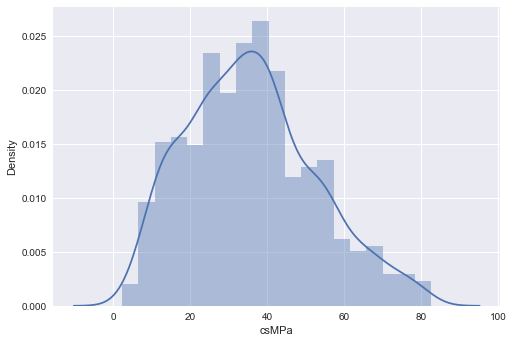

In [11]:
import seaborn as sns
sns.distplot(df.csMPa);

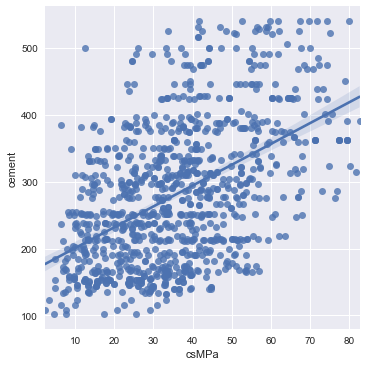

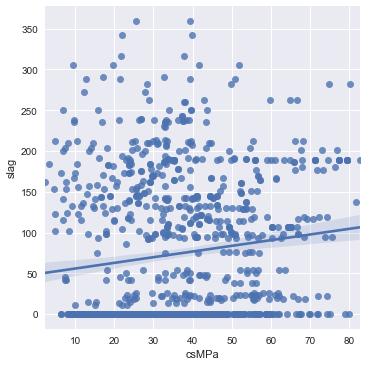

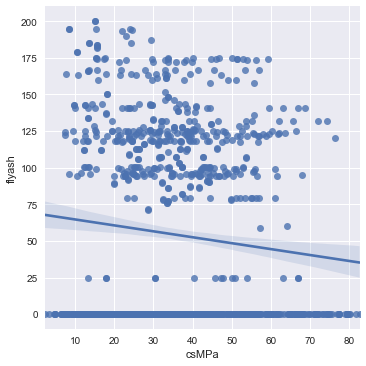

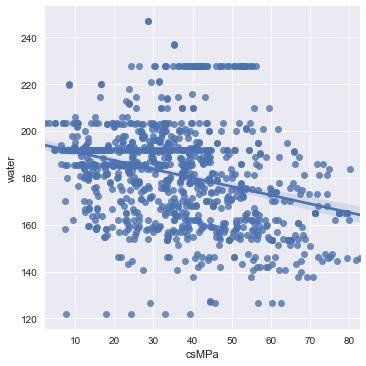

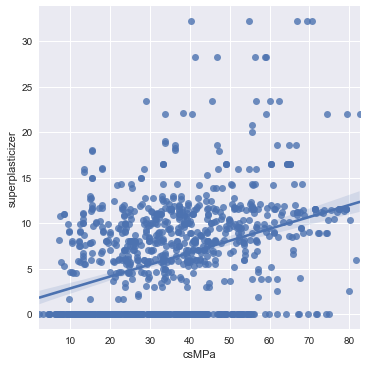

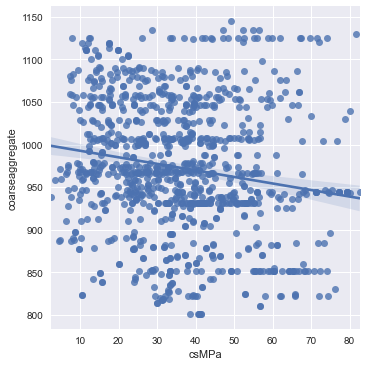

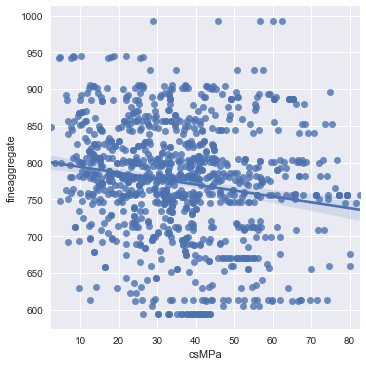

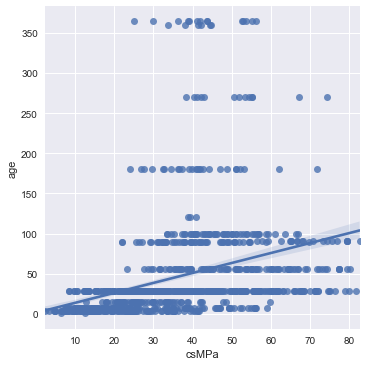

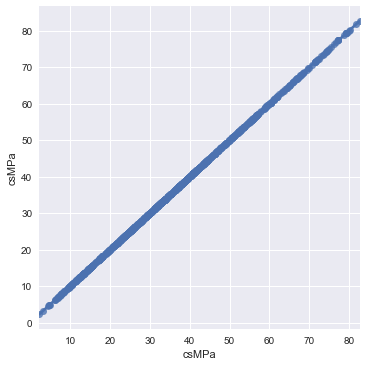

In [12]:
import matplotlib.pyplot as plt


for column in df:
    sns.lmplot(x = "csMPa", y = column, data = df);

In [39]:
# this function is the main function for regression
def regression():
    num_neighbors = [1, 3, 5, 7, 9]
    k_folds = 5
    data = read_csv_file("Concrete_Data_Yeh.csv")
    target = "csMPa"
    normalized_data = normalize_dataset(data, target)
    
    # invokes KNN regression function by changing data and algorithm types

     # KNN regression without feature normalization
    for num in num_neighbors:
        scores = knn_regression(data, k_folds, num, "normal", target)
   
     # KNN regression with feature normalization
    for num in num_neighbors:
        scores = knn_regression(normalized_data, k_folds, num, "normal", target)
        
    # weighted KNN regression without feature normalization
    for num in num_neighbors:
        scores = knn_regression(data, k_folds, num, "weighted", target)

    # weighted KNN regression with feature normalization
    for num in num_neighbors:
        scores = knn_regression(normalized_data, k_folds, num, "weighted", target)


In [36]:
# cross validation, csMPa prediction and mean absolute error calculation are done here
def knn_regression(dataset, n_folds, k_neighbors, algo_type, target):
    # splits data into 5 folds
    folds = cross_validation_splitter(dataset, n_folds)
    results = list()

    # create test and train sets
    for i in range(len(folds)):
        train_set = deepcopy(folds)
        test_set = train_set.pop(i)
        # original -> keeps original types for accuracy metric comparison
        original = list()

        for row in folds[i].iterrows():
            original.append(row[1][target])

        # according to algorithm type, call prediction functions
        predictions = list()
        for row in test_set.iterrows():
            if algo_type == "normal":
                output = predict_csMPa(train_set, row, k_neighbors, target)
                predictions.append(output)
            elif algo_type == "weighted":
                output = predict_weighted_csMPa(train_set, row, k_neighbors, target)
                predictions.append(output)
        
        # calculate mean absolute error
        mea = mean_absolute_error(original, predictions)
        results.append(mea)
    return results

For each test row, we get the nearest neighbors and predict its type. Lastly, we compare the predicted and actual values and calculate the accuracy of our algorithm.
For each test row, we average the csMPa values of its nearest neighbors and estimate the test row's csMPa value. Finally, we compare the predicted and actual values and calculate the mean absolute error of our algorithm.


In [33]:
def predict_csMPa(train_data, test_row, k, target):
    distances = dict()

    for train in train_data:
        for train_row in train.iterrows():
            distances[calculate_euclidean_distance(train_row, test_row)] = train_row[1][target]
    sorted_distances = sorted(distances.items(), key=lambda x: x[0])[:k]
    # get the average of distances
    return reduce(lambda a, b: a + b, [item[1] for item in sorted_distances]) / len([item[1] for item in sorted_distances])

We are looping over each point of the test data set, to find the euclidian distance between the test point and train data points. Then we are sorting the distance and finding the nearest K neighbours. Since we have the target values of the nearest neighbours, we average of those values and equate the predicted target variable.

In [32]:
def predict_weighted_csMPa(train_data, test_row, k, target):
    distances = dict()

    for train in train_data:
        for train_row in train.iterrows():
            distances[calculate_euclidean_distance(train_row, test_row)] = train_row[1][target]
    sorted_distances = sorted(distances.items(), key=lambda x: x[0])[:k]
    
    # x -> calculates weighted distance, y -> calculates total distance 
    x = reduce(lambda a, b: a + b, [(1/item[0]*item[1]) if item[0] != 0 else (item[1]) for item in sorted_distances])
    y = reduce(lambda a, b: a + b, [(1/item[0]) if item[0] != 0 else (item[1]) for item in sorted_distances])

    return x/y

In weighted k-NN model, the algorithm will still look at all k nearest neighbors, but the closer neighbors will have more of a vote than those further away.  The "predict_weighted_csMPa" function predicts the target variable "csMPa" of the query point using distance-weighted voting.

In [28]:
def mean_absolute_error(original, predicted):
    error = 0
    for i in range(len(original)):
        error += abs(original[i] - predicted[i])
    return error / len(original)

The "mean_absolute_error" function allows us to measure the accuracy of the model by comparing the actual values ​​and the predicted values. The returned value tells us that the average difference between the actual data value and the value predicted by the model.

### ANALYSIS FOR REGRESSION